In [1]:
# Load Dependencies
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import shap

# Load Data
df = pd.read_csv('data/organized.csv.gz', compression='gzip')

# Select columns 
exclude = ['account_id', 'is_current_customer', 'is_self_service', 'country', 'state', 'country_top', 'state_top', 'industry_grouped', 'company_revenue_bucket', 'dnb_founded_time_grouped', 'cluster']

float64_columns = df.select_dtypes(include='float64').columns
df[float64_columns] = df[float64_columns].astype('int')



In [2]:
# Split the data into features (X) and target variable (y)
df_filtered = df[df['is_arr_over_12k'] != 0].copy()
df_filtered['is_arr_over_12k'].replace(({1: 1, -1: 0, 0: np.nan}), inplace=True)

X = df_filtered.drop(['is_arr_over_12k'] + exclude, axis=1)
y = df_filtered['is_arr_over_12k']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Filter for 'object'
X_train.select_dtypes(include='object').columns

# Standardize the data if needed (especially for Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)


# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predictions on validation set
rf_valid_preds = rf_model.predict(X_valid)

# Evaluate F1 and AUC
rf_f1 = f1_score(y_valid, rf_valid_preds, average='binary')
rf_auc = roc_auc_score(y_valid, rf_model.predict_proba(X_valid)[:, 1])

print(f"Random Forest - F1: {rf_f1}, AUC: {rf_auc}")


# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions on validation set
xgb_valid_preds = xgb_model.predict(X_valid)

# Evaluate F1 and AUC
xgb_f1 = f1_score(y_valid, xgb_valid_preds)
xgb_auc = roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

print(f"XGBoost - F1: {xgb_f1}, AUC: {xgb_auc}")

# Initialize the Lasso model
lasso_model = Lasso(random_state=42)

# Train the model
# lasso_model.fit(X_train_scaled, y_train)
lasso_model = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10], cv=5)
lasso_model.fit(X_train_scaled, y_train)
optimal_alpha = lasso_model.alpha_

# Predictions on validation set
lasso_valid_preds = (lasso_model.predict(X_valid_scaled) > 0.5).astype(int)

# Evaluate F1 and AUC
lasso_f1 = f1_score(y_valid, lasso_valid_preds)
lasso_auc = roc_auc_score(y_valid, lasso_model.predict(X_valid_scaled))

print(f"Lasso - F1: {lasso_f1}, AUC: {lasso_auc}")

# Print feature coefficients for Lasso model
lasso_coefficients = pd.Series(lasso_model.coef_, index=X_train.columns)
lasso_feature_importance = lasso_coefficients.abs().sort_values(ascending=False)

print("Lasso Feature Coefficients:")
print(lasso_feature_importance)


# Initialize the Logistic Regression model
logistic_model = LogisticRegression(random_state=42)

# Train the model
logistic_model.fit(X_train, y_train)

# Predictions on validation set
logistic_valid_preds = logistic_model.predict(X_valid)

# Evaluate F1 and AUC
logistic_f1 = f1_score(y_valid, logistic_valid_preds)
logistic_auc = roc_auc_score(y_valid, logistic_model.predict_proba(X_valid)[:, 1])

print(f"Logistic Regression - F1: {logistic_f1}, AUC: {logistic_auc}")

# Initialize the Gradient Boosting model
# For LightGBM:
gb_model = LGBMClassifier(random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Predictions on validation set
gb_valid_preds = gb_model.predict(X_valid)

# Evaluate F1 and AUC
gb_f1 = f1_score(y_valid, gb_valid_preds)
gb_auc = roc_auc_score(y_valid, gb_model.predict_proba(X_valid)[:, 1])

print(f"Gradient Boosting - F1: {gb_f1}, AUC: {gb_auc}")

Random Forest - F1: 0.6311557788944723, AUC: 0.7708524803834742
XGBoost - F1: 0.6430868167202571, AUC: 0.8049853547446093


Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16873000576129016, tolerance: 0.11867166130329852
Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.80660179308927, tolerance: 0.11867166130329852
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9304779351047046, tolerance: 0.1184134151246989
Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.4853078215594, tolerance: 0.1184134151246989
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6921830221548362, tolerance: 0.11783401045856735
Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.11084814287824, tolerance: 0.11783401045856735
Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.88280119086858, tolerance: 0.1180151

Lasso - F1: 0.6181015452538632, AUC: 0.8014845777225016
Lasso Feature Coefficients:
som_distance                                                     0.111149
crossbeam_product11_customer_max_crossbeam_product20_customer    0.046780
crossbeam_product8_customer_max_crossbeam_product20_customer     0.033956
crossbeam_product20_customer_max_hg_product_67                   0.030456
industry_nan                                                     0.030446
                                                                   ...   
hg_product_136                                                   0.000000
hg_product_135                                                   0.000000
hg_product_134                                                   0.000000
hg_product_133                                                   0.000000
activation_distance                                              0.000000
Length: 420, dtype: float64


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Logistic Regression - F1: 0.6267087276550999, AUC: 0.7767965204687436
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2417, number of negative: 3798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1387
[LightGBM] [Info] Number of data points in the train set: 6215, number of used features: 417
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388898 -> initscore=-0.451948
[LightGBM] [Info] Start training from score -0.451948
Gradient Boosting - F1: 0.631578947368421, AUC: 0.8083357403910654


In [3]:

# Additional Evaluation Criteria
# Define and print other evaluation metrics for each model
metrics_list = []  # Use a list to store dictionaries
for model, preds in zip(['Random Forest', 'XGBoost', 'Lasso', 'Logistic Regression', 'Gradient Boosting'],
                        [rf_valid_preds, xgb_valid_preds, lasso_valid_preds, logistic_valid_preds, gb_valid_preds]):
    accuracy = accuracy_score(y_valid, preds)
    precision = precision_score(y_valid, preds)
    recall = recall_score(y_valid, preds)
    specificity = recall_score(1 - y_valid, 1 - preds)
    f1 = f1_score(y_valid, preds)

    metrics_dict = {'Model': model, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'Specificity': specificity, 'F1': f1}
    metrics_list.append(metrics_dict)

# Convert the list of dictionaries to a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Print evaluation metrics
print("## Evaluation Metrics\n")
print(metrics_df.to_markdown(index=False))

# Find the winner based on F1 Score
winner = metrics_df.loc[metrics_df['F1'].idxmax(), 'Model']
print(f"\nWinner based on F1 Score: {winner}")

## Evaluation Metrics

| Model               |   Accuracy |   Precision |   Recall |   Specificity |       F1 |
|:--------------------|-----------:|------------:|---------:|--------------:|---------:|
| Random Forest       |   0.724474 |    0.646091 | 0.616896 |      0.791009 | 0.631156 |
| XGBoost             |   0.75     |    0.707547 | 0.589391 |      0.849332 | 0.643087 |
| Lasso               |   0.74024  |    0.70529  | 0.550098 |      0.857837 | 0.618102 |
| Logistic Regression |   0.733483 |    0.674208 | 0.585462 |      0.82503  | 0.626709 |
| Gradient Boosting   |   0.742492 |    0.696682 | 0.577603 |      0.844471 | 0.631579 |

Winner based on F1 Score: XGBoost


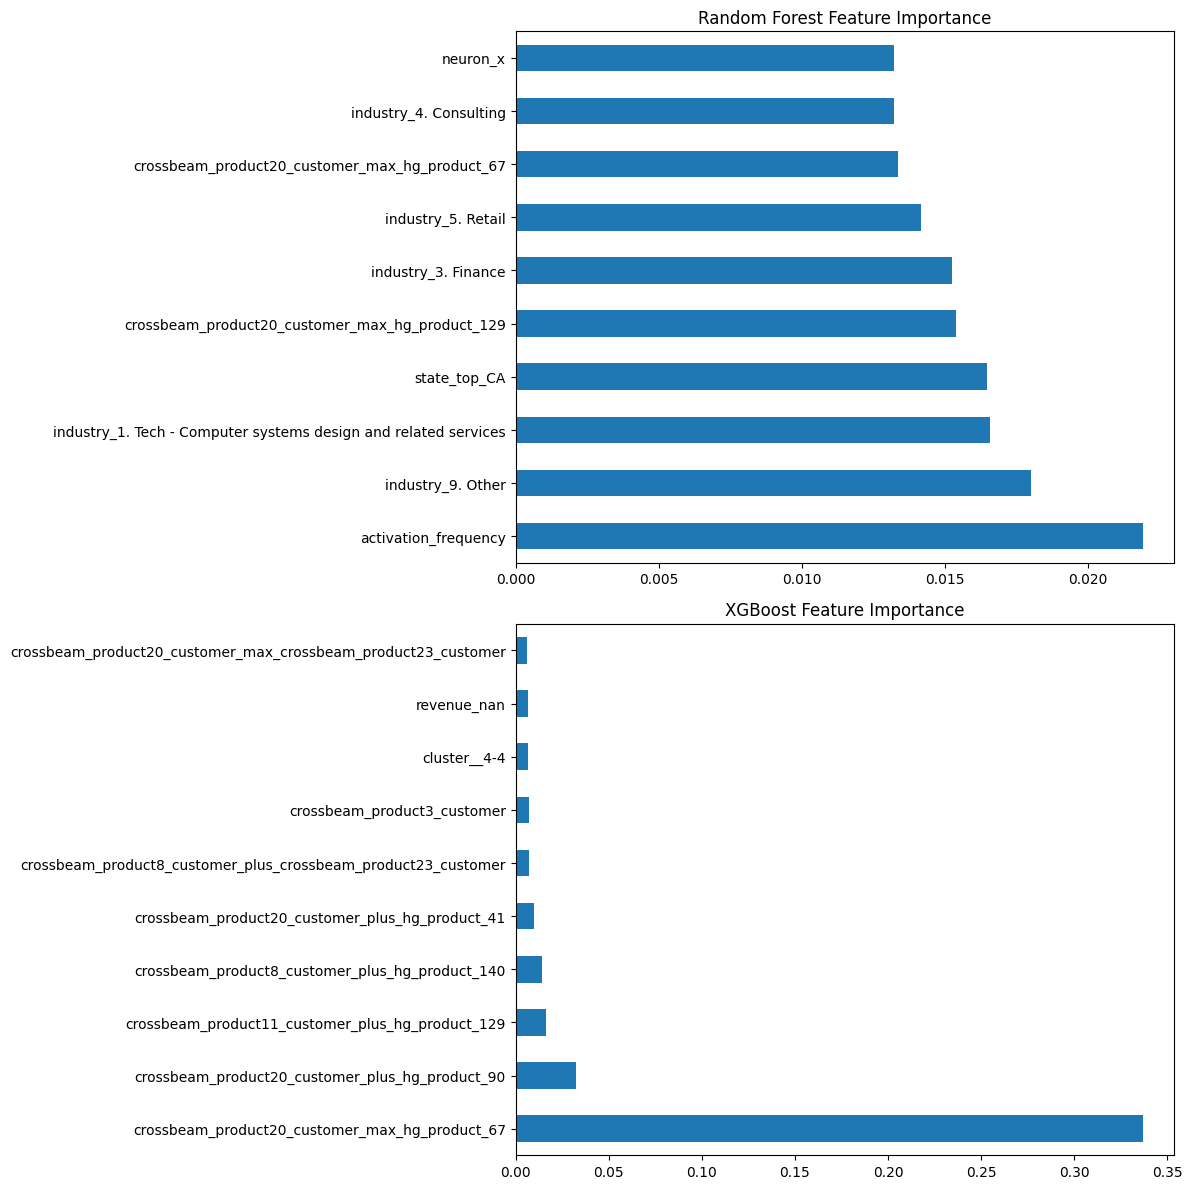

In [4]:
# Visualization of Feature Importance
# Plot feature importance for Random Forest and XGBoost models
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Random Forest
feature_importance_rf = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importance_rf.nlargest(10).plot(kind='barh', ax=axes[0], title='Random Forest Feature Importance')

# XGBoost
feature_importance_xgb = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
feature_importance_xgb.nlargest(10).plot(kind='barh', ax=axes[1], title='XGBoost Feature Importance')

plt.tight_layout()
plt.show()



Top 5 Account IDs with Highest Predicted Probabilities for is_arr_over_12k=1 (Unknown Class):
| Account ID         |   Predicted Probability |
|:-------------------|------------------------:|
| 0011G00000qE5cdQAC |                0.999728 |
| 0011G00000tM2osQAC |                0.999718 |
| 0011G00000f9KamQAE |                0.999638 |
| 0011G00000qeg53QAA |                0.99946  |
| 0011G00000gY3rPQAS |                0.999416 |


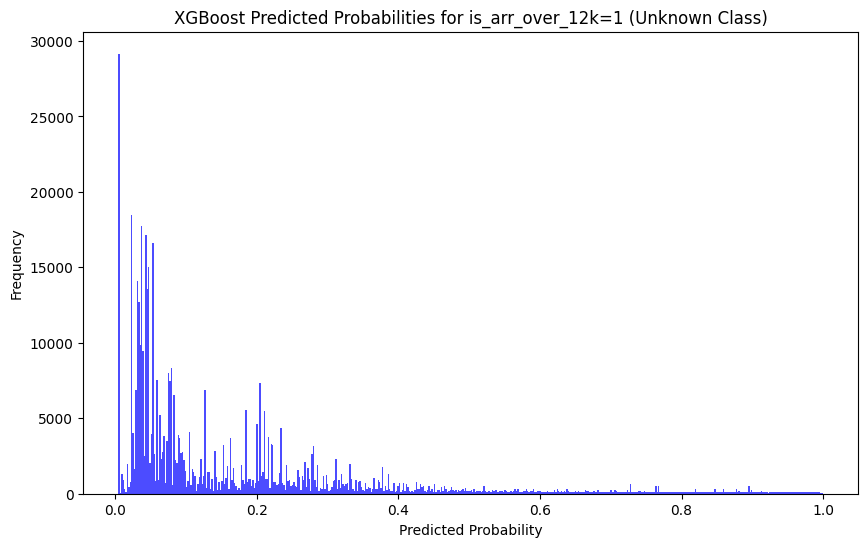

Predicted Probability for the 2000th Account: [0.9582011]


In [5]:
# Get predicted probabilities for `is_arr_over_12k=0` from XGBoost
df_new = df[df['is_arr_over_12k'] == 0].copy()
X_new = df_new.drop(['is_arr_over_12k'] + exclude, axis=1)

# Get predicted probabilities for class 0 from XGBoost for the new data
xgb_probabilities_new = xgb_model.predict_proba(X_new)[:, 1]

# Filter for 'is_arr_over_12k=0'
xgb_probabilities_0_new = xgb_probabilities_new  # assuming is_arr_over_12k is binary (0 or 1)

# Get the original account IDs corresponding to X_new
original_account_ids_new = df_new['account_id']

# List the top 5 account IDs with the highest predicted probabilities for new data
top_5_accounts_new = original_account_ids_new.iloc[np.argsort(xgb_probabilities_0_new)[-5:]][::-1]

# Create a DataFrame with Account ID and Predicted Probability for new data
top_5_df_new = pd.DataFrame({'Account ID': top_5_accounts_new.values,
                             'Predicted Probability': xgb_probabilities_0_new[np.argsort(xgb_probabilities_0_new)[-5:]][::-1]})

# Print as a Markdown table
print("Top 5 Account IDs with Highest Predicted Probabilities for is_arr_over_12k=1 (Unknown Class):")
print(top_5_df_new.to_markdown(index=False))

# Visualize the distribution via histogram for new data
plt.figure(figsize=(10, 6))
plt.hist(xgb_probabilities_0_new, bins=500, color='blue', alpha=0.7)
plt.title('XGBoost Predicted Probabilities for is_arr_over_12k=1 (Unknown Class)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()


# Sort accounts based on predicted probabilities
sorted_accounts = original_account_ids_new.iloc[np.argsort(xgb_probabilities_new)][::-1]

# Select the top 2000 accounts
top_2000_accounts = sorted_accounts.head(2000)

# Get the predicted probability for the 2000th account
predicted_probability_2000th_account = xgb_probabilities_new[original_account_ids_new == top_2000_accounts.iloc[-1]]

# Print the predicted probability for the 2000th account
print(f"Predicted Probability for the 2000th Account: {predicted_probability_2000th_account}")

In [12]:
# Print feature coefficients for Logistic Regression model
logistic_coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': logistic_model.coef_[0]})
logistic_coefficients['Abs_Coefficient'] = logistic_coefficients['Coefficient'].abs()

# Sort by absolute values of coefficients
logistic_coefficients = logistic_coefficients.reindex(logistic_coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Print the top 10 features as a Markdown table
print("\nTop 10 Features and Association for Logistic Regression:")
print(logistic_coefficients[['Feature', 'Coefficient']].head(10).to_markdown(index=False))



Top 10 Features and Association for Logistic Regression:
| Feature             |   Coefficient |
|:--------------------|--------------:|
| state_top_Missing   |    -0.254647  |
| revenue_nan         |    -0.157121  |
| bmu_y               |     0.142434  |
| neuron_y            |     0.142434  |
| neuron_x            |    -0.141452  |
| bmu_x               |    -0.141452  |
| country_top_US      |     0.124906  |
| country_top_Other   |    -0.113162  |
| activation_distance |     0.088013  |
| industry_nan        |    -0.0787086 |


In [6]:
## Feature Importance with SHAP (SHapley Additive exPlanations)
## Takes too long to run

# import shap

# # SHAP for Random Forest
# explainer_rf = shap.TreeExplainer(rf_model)
# shap_values_rf = explainer_rf.shap_values(X_train)

# # SHAP for XGBoost
# explainer_xgb = shap.TreeExplainer(xgb_model)
# shap_values_xgb = explainer_xgb.shap_values(X_train)

# # Visualization of SHAP values
# shap.summary_plot(shap_values_rf, X_train, plot_type="bar", show=False)
# plt.title('SHAP Values - Random Forest')

# shap.summary_plot(shap_values_xgb, X_train, plot_type="bar", show=False)
# plt.title('SHAP Values - XGBoost')

# plt.show()